# GroMore base model domain
## Model Description before GroMore proposal 
This is a steady state box model with recharge and ET. An additional layer was also added to the model.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 1000 m
- dz = varied 
- three layers

#### Topography
- Top layer elevation given in csv file
- Middle layer is flat and 5m thick
- Bottom layer (Layer 3) is flat and 40m thick

#### Subsurface Properties: 
- Porosity = 0.1
- Specific yield = 0.1
- Storage coefficient=0.0001 
- Homogeneous in each layer
##### Layers
 - Layer 1 = Layer 3
     - Kx=Ky=Kz= 10m/d
 - Layer 2 
     - 20 leftmost columns, Kx=Ky=Kz= 10m/d
     - Other columns, Kz= 0.0001m/d

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to datum for all layers (datum is at bottom of domain)
 - All other boundaries are no flow
 - Top left corner: no flow
     - Extends from row 45, column 1 to row 50, column 6, inclusive, comprising a total of 21 no flow cells
 - A symmetric no flow region exists in the bottom left corner
     - row 41, column 1 to row 50, column 10.
 - Middle layer has no flow regions
     - Extends from row 43, column 1 to row 50, column 8 
 
#### ET: 
- Zero in left half
- 1E-5 m/day in the right half of the domain
- Riparian zone
    - Extends from left to right boundary of rows 23 to 29, inclusive
    - Rate: 5E-5m/d
- Extinction depth= 10m
 
#### Recharge: 
 - Leftmost 15 columns at a rate of 4E-5 m/d
 - Zero everywhere else

#### Stream:
- Begins in left boundary and goes to the right in row 26
- width=length=thickness= 1.0
- No flow is entering the stream
- streambed
    - K= 1000m/d
    - elevation= 1.0m below ground surface
    - stage= 0.5m
- "weak sink" with strength 0.5 (This is set under MODPATH/Particle Options.)
 
#### Well: 
 - Pumping well for Aquaseca
     - Completed in bottom layer
     - Located at row 21, column 38
     - Pumping at a rate of 1500 m^3/day 

## Model Description after GroMore proposal 

#### Ag field:
- cover a 2000m by 2000m area
- 1/8th of the area will be irrigated agriculture at any time (the field area is multiplied by 0.125). 
- Rectangular irrigated fields extend between rows 21 and 22 (inclusive) and columns 19 and 20 (inclusive).

##### ET
- ET for the crop is zero - it is accounted for in the calculated recharge 

##### Recharge
- Rate is 20% of the water demand of the crop, representing intentional excess irrigation to avoid soil salinization
- Crop water uses/recharge rates:
    - Wheat= 0.004m/d / 0.0001m/d
    - Pistachios= 0.006m/d / 0.00015m/d
    - Cotton: 0.008 m/d / 0.0002 m/d
    
##### Pumping Well:
- Completed in top layer
- Row 12 and column 14
- Pumping rate equal to the crop water demand plus 20% for excess irrigation plus 30% for irrigation inefficiency
    - Wheat= 3000 m3/day
    - Pistachos= 4500 m3/d
    - Cotton= 6000 m3/d
    
##### Monitoring wells
- Two monitoring in transient conditions
    - One at [25000, 25000] 
    - Other at [12500, 12500].

*For simplicity, we will consider a year to be comprised of 12 30-day months.

## 1. Import packages

In [1]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

flopy is installed in C:\Users\vivek\Anaconda3\lib\site-packages\flopy


# The following outlines our 10 ensembles 

## The high drawdown set

### Ensemble 1
KU and KL, HKM: [5] - low
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 2
KU and KL, HKM: 
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 3
KU and KL, HKM: [5] - low
VKM:[1] - high
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 4
KU and KL, HKM: [5] - low
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [5e-5] - high
VETR:[1e-4] - high
RETR: [3] - high
SK: [1e-2] - low
### Ensemble 5
KU and KL, HKM: [5] - low
VKM:[1e-6] - low
SY:[0.05] - low
MRR: [1e-5] - low
VETR:[1e-4] - high
RETR: [3] - high
SK: [1] - high


## The low drawdown set

### Ensemble 6
KU and KL, HKM: [100] - high
VKM:[1] - high
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1e-2] - low
### Ensemble 7
KU and KL, HKM: [100] - high
VKM:[1] - high
SY:[.3] - high
MRR: [1e-5] - low
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high
### Ensemble 8
KU and KL, HKM: [100] - high
VKM:[1e-6] - low
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high
### Ensemble 9
KU and KL, HKM: [5] - low
VKM:[1] - high
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high
### Ensemble 10
KU and KL, HKM: [100] - high
VKM:[1] - high
SY:[.3] - high
MRR: [5e-5] - high
VETR:[1e-6] - low
RETR: [1] - low
SK: [1] - high

## Setting up variable lists for ensembles

In [2]:
# #K upper and lower layers (isotropic) and horiz k middle layer list
# k_ulm = [5,100,5,5,5,100,100,100,5,100]
# #vertical K middle layer list
# vka_mid = [1e-6,1e-6,1,1e-6,1e-6,1,1,1e-6,1,1]
# #specific yield list 
# sy = [.05,.05,.05,.05,.05,.3,.3,.3,.3,.3]
# #mountain recharge list
# mrr = [1e-5,1e-5,1e-5,5e-5,1e-5,5e-5,1e-5,5e-5,5e-5,5e-5]
# #Valley ET rate list 
# vetr = [1e-4,1e-4,1e-4,1e-4,1e-4,1e-6,1e-6,1e-6,1e-6,1e-6]
# #Riparian ET rate list
# retr = [3,3,3,3,3,1,1,1,1,1]
# #streambed K list
# streambed_k = [1e-2,1e-2,1e-2,1e-2,1,1,1,1,1]

## 2. setting up static (outside loop) inputs

In [3]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

ztop = np.genfromtxt('base_model_elevs.csv', delimiter=',', dtype=float)   # top elevation of top layer (import from csv file) (dim: nrow,ncol)

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
#Sy = 0.1        #assign specific yield #changed in loop
uncnf = 1       #0=confined, >0 = unconfined

#supply well
pumping = 0 #m3/day 
well_xy= [38000, 29000] #xy location of well 
well_row = np.floor((nrow)-(well_xy[1]/dy)) #convert the y location to a row
well_col=np.floor(well_xy[0]/dx) #convert the x location to a column
well_row = 29
well_col = 37
well_loc = (0,well_row, well_col)
well = [2,well_row, well_col, pumping] #Well loc shoudl be layer, row, column
#print("well1 location(layer, col, row)", well_row, well_col)


#MW1
pumping2 = 0 #m3/day 
well2_xy= [25000, 25000] #xy location of well 
well2_row = np.floor((nrow)-(well2_xy[1]/dy)) #convert the y location to a row
well2_col=np.floor(well2_xy[0]/dx)-1 #convert the x location to a column
well2_loc = (0,well2_row, well2_col)
well2 = [0,well2_row, well2_col, pumping2] #Well loc shoudl be layer, row, column
#print("well2 location(layer, col, row)", well2_row, well2_col)

#MW2
pumping3 = 0 #m3/day 
well3_xy= [12500, 12500] #xy location of well 
well3_row = np.floor((nrow)-(well3_xy[1]/dy)) #convert the y location to a row
well3_col=np.floor(well3_xy[0]/dx) #convert the x location to a column
well3_loc = (0,well3_row, well3_col)
well3 = [0,well3_row, well3_col, pumping3] 
#print("well3 location(layer, col, row)", well3_row, well3_col)


#irrigation well
pumping4 = 0 #m3/day 
well4_row = 38 
well4_col = 12 
well4_loc = (0,well4_row, well4_col)
well4 = [0,well4_row, well4_col, pumping4] 
#print("well4 location(layer, col, row)", well4_row, well4_col)

wel_spd = {0: [well, well2, well3, well4]}
print(wel_spd)


## Make some changes to the parameters
bot_elev = 0.
mid_elev = 40.
top_elev = 45.

botm = np.zeros((nlay,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[2,:,:] = bot_elev                 # bottom elevation of lowest layer (2) is 0 m
botm[1,:,:] = mid_elev                 #bottom elevation of middle layer (1) is 40 m           
botm[0,:,:] = top_elev                 # bottom elevation of top layer (0) 45 

{0: [[2, 29, 37, 0], [0, 25.0, 24.0, 0], [0, 37.0, 12.0, 0], [0, 38, 12, 0]]}


### Boundary Conditions

In [4]:
## Boundary conditions for initial steady state
h_right = 70

H_init = np.ones((nlay, nrow, ncol), dtype=np.float32) 
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value


# #read in burn-in head values
# #print(os.getcwd())
# H_init = np.ones((nlay, nrow, ncol), dtype=np.float32) 
# H_init[0,:,:] = np.loadtxt('top_head_spinup_200yr.csv', delimiter=",")
# H_init[1,:,:] = np.loadtxt('mid_head_spinup_200yr.csv', delimiter=",")
# H_init[2,:,:] = np.loadtxt('bot_head_spinup_200yr.csv', delimiter=",")

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

### Seasons and Stressperiods

In [5]:
# #sp_peryr = 2   #number of seasons (with and wihtout ET. April-Sept and Oct-Mar)
# sp1_len = 180  #sp lengths
# #sp2_len = 180
# sim_years = 100
# nper = int(sp_peryr*sim_years)

# #setup the steady state array
# steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
# #print(steady)
# # steady[0] = True    # initial stress period is steady-state

# #make an array of period lengths
# perlen=np.tile([sp1_len, sp2_len],sim_years)
# #perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
# #print("Period lengths", perlen)

# #make an nstp array for the # of time steps to solve within each period in this case we will do daily 
# #so we can repeat the perlen array
# nstp=perlen/30 #30 for monthly
# #nstp[0]=1 #for the steady state solution we just want one output
# nstp = nstp.astype(int)
# #print("Number of Steps", nstp)



# ## Boundary conditions
# h_right = 70


### Set up varying ET & Pumping

In [6]:
                      
# ET_dict = {} #set up an ET dictionary, where each key is a stress period num 0-50
# ET_zone2 = ET_zone * 0 
# # for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
# #     if p == 0:
# #         ET_dict[p] = ET_zone
# #     elif int(p % 2) != 0:
# #         ET_dict[p]=ET_zone2
# #         #print(p)
# #     else: 
# #         ET_dict[p] = ET_zone

# #No steady state test
# for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
#     if p == 0:
#         ET_dict[p] = ET_zone2
#     elif int(p % 2) != 0:
#         ET_dict[p]=ET_zone
#         #print(p)
#     else: 
#         ET_dict[p] = ET_zone2


# #WELL STRESS PERIODS
# #init_well = [well, well2, well3, well4]
# #
# wel_spd = {}    
    
# burn = 0 #0 because of the head file read in
# decade = 1
# decade2 = 10 #to calculate pumping after 100 year pumping
# pump = 47

# for strper in range(0, nper):    
#     if strper < burn:
#         pumping = 0
#         wel_spd[strper] = [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
#     elif strper < (burn+decade*20): # 20 for 2 stress periods per 10 years
#         pumping = round(pump * (decade2**1.5)) *-1
#         wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
#     else:
#         decade = decade + 1   
#         decade2 = decade2 +1
#         pumping = round(pump * (decade2**1.5)) *-1
#         wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, well4_row, well4_col, pumping4]]
    
# #print(wel_spd)

## 3. Run Modflow Ensembles in a loop

In [7]:
#set up variable lists
#K upper and lower layers (isotropic) and horiz k middle layer list
k_ulm = [5,100,5,5,5,100,100,100,5,100]
#vertical K middle layer list
vka_mid = [1e-6,1e-6,1,1e-6,1e-6,1,1,1e-6,1,1]
#specific yield list 
sy = [.05,.05,.05,.05,.05,.3,.3,.3,.3,.3]
#mountain recharge list
mrr = [1e-5,1e-5,1e-5,5e-5,1e-5,5e-5,1e-5,5e-5,5e-5,5e-5]
#Valley ET rate list 
vetr = [1e-4,1e-4,1e-4,1e-4,1e-4,1e-6,1e-6,1e-6,1e-6,1e-6]
#Riparian ET rate list
retr = [3,3,3,3,3,1,1,1,1,1]
#streambed K list
streambed_k = [1e-2,1e-2,1e-2,1e-2,1,1e-2,1,1,1,1]


## Timing
nper = 1 #number of stress periods 
steady = [True] #list noting the stress period type


#loop start
for x in range(10):
    modelname = "ensemble_" + str(x)
    #moddir="/Users/hardknox47/Desktop/HWRS482/MODFLOW/pymake/examples/mf2005"
    #moddir="/Users/amanda_triplett/Documents/Courses/groundwater_Modeling/pymake/examples/mf2005"
    moddir="C:\WRDAPP\MODFLOW\mf2005"
    print(modelname)
    
    m = flopy.modflow.Modflow(modelname, exe_name = moddir)

    #Discretization - dis
    dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)

    # Boundary and initial conditions - bas
    bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

    
    
    
    
    # setting up layer properties 
    Sy = sy[x]
    
    K_horiz = k_ulm[x] #m/d
    K_vert = k_ulm[x] #m/d
    K_vert2 = vka_mid[x] #m/d  #K for the middle layer 


    # make horizontal K np arrays
    Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kh[:,:,:] = K_horiz # assign the original value to the entire array

    ## Make a arrays for the K values
    Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
    Kz[:,:,:] = K_vert                   # assign the original value to the entire array
    Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
    Kz[1,:,:] = K_vert2
    
    #Layer properties - lpf
    lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
    
    
    
    
    ## ET set up
    ET = vetr[x] #m/day
    ET_locxy=[[24000,0], [0, 0]] #lower left and upper right corners of ET in xy coordinate
    rip_ET= retr[x]  #riparian zone
    rip_locxy= [[0,21000],[23000,0]]
    extinction_depth = 10 #m

    ET_rows_forced=(1.0, 49.0) #me forcing the et_rows to be 0-50
    ET_cols_forced = (26.0, 49.0)

    ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
    ET_zone[0,int(ET_rows_forced[0]):int(ET_rows_forced[1]), int(ET_cols_forced[0]):int(ET_cols_forced[1])] = ET 

    rip_rows_forced = (21.0, 28.0)  #forced riparian area
    rip_cols_forced = (1.0, 49.0)


    rip_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
    ET_zone[0,int(rip_rows_forced[0]):int(rip_rows_forced[1]), int(rip_cols_forced[0]):int(rip_cols_forced[1])] = rip_ET 


    #ET - evt
    evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_zone, exdp=extinction_depth, ipakcb=53) 

    
    
    
    # Recharge - will be done in the loop
    rech= mrr[x]  #m/d
    rechxy=[(0,0),(0,36000)]  #recharge zone

    rech_rows_forced = (1.0, 49.0) #rech zone forced for leftmost 15 cols
    rech_cols_forced = (1.0, 15.0)

    agrech_rows_forced = (28.0, 30.0) #rech zone forced for leftmost 15 cols
    agrech_cols_forced = (18.0, 20.0)
    agrech = 0.00015  #pistachios (1/8th area already included)

    rech_zone_no_ag = np.zeros((1, nrow,ncol))
    rech_zone_ag = np.zeros((1, nrow,ncol))
    
    rech_zone_no_ag[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
    
    rech_zone_ag[0, int(rech_rows_forced[0]):int(rech_rows_forced[1]),int(rech_cols_forced[0]):int(rech_cols_forced[1])]=rech
    rech_zone_ag[0, int(agrech_rows_forced[0]):int(agrech_rows_forced[1]),int(agrech_cols_forced[0]):int(agrech_cols_forced[1])]=agrech
    
    
    R = {}                                             # create empty dictionary for recharge fluxes
    for p in range(0,nper):                            # loop over stress periods, skipping initial steady state defined above
        if p <= 101:
            R[p]=rech_zone_no_ag
        else:
            R[p]=rech_zone_ag


    #Recharge - rch
    rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=R, ipakcb=53)     #create rch object

    
    
    #DEFINE RIVERS
    riv_row= 24
    riv_sp = [] #create list to store all river cells for stress period 1
    k_rivbott = streambed_k[x] #river bottom hydraulic conductivity in m/d
    sed_thick = 1 #thickness of riverbed sediment in m
    cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
    r_stage = .5 #stage in river (stress period 1)
    r_bott = ztop[riv_row,:] #river bottom
    for i in range(1,ncol):
        riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
    #create dictionary of stress period data
    riv_spd = {0: riv_sp}
  
    #River - riv
    riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

    #Well - wel
    wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)


    #oc package
    #oc_spd = {}
    #for kper in range(0, nper):
    #    for kstp in range(nstp[kper]):
    #        #print(kstp)
    #        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
    
    oc_spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
    oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

    
    #Numerical solver - pcg
    pcg = flopy.modflow.ModflowPcg(model=m, mxiter=5000, iter1=100, relax = 0.95, damp = 0.1)


    #write the inputs
    m.write_input()   
    m.check()



    #Run the model 
    success, mfoutput = m.run_model(pause=False, report=True)
    if not success:
        raise Exception('MODFLOW did not terminate normally.')

ensemble_0

ensemble_0 MODEL DATA VALIDATION SUMMARY:
  1 Warning:
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08 for 1 stress periods

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker threshold of 1e-11
    LPF package: horizontal hydraulic conductivity values above checker threshold of 100000.0
    LPF package: vertical hydraulic conductivity values below checker threshold of 1e-11
    LPF packa

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/30  6:58:34
 Elapsed run time:  1.628 Seconds

  Normal termination of simulation
ensemble_5

ensemble_5 MODEL DATA VALIDATION SUMMARY:
  1 Warning:
    RCH package: Mean R/T ratio < checker warning threshold of 2e-08 for 1 stress periods

  Checks that passed:
    Compatible solver package
    Unit number conflicts
    DIS package: zero or negative thickness
    DIS package: thin cells (less than checker threshold of 1.0)
    DIS package: nan values in top array
    DIS package: nan values in bottom array
    BAS6 package: isolated cells in ibound array
    BAS6 package: Not a number
    LPF package: zero or negative horizontal hydraulic conductivity values
    LPF package: zero or negative vertical hydraulic conductivity values
    LPF package: negative horizontal anisotropy values
    LPF package: horizontal hydraulic conductivity values below checker t

 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/04/30  6:58:47
 Elapsed run time:  2.665 Seconds

  Normal termination of simulation


## Reading Steady State Head

Head at Community well for ensemble_0 = 71.069786
Head at Community well for ensemble_1 = 69.971954
Head at Community well for ensemble_2 = 66.39057
Head at Community well for ensemble_3 = 72.88452
Head at Community well for ensemble_4 = 71.233795
Head at Community well for ensemble_5 = 66.01494
Head at Community well for ensemble_6 = 66.13032
Head at Community well for ensemble_7 = 70.04481
Head at Community well for ensemble_8 = 67.208885
Head at Community well for ensemble_9 = 66.234726


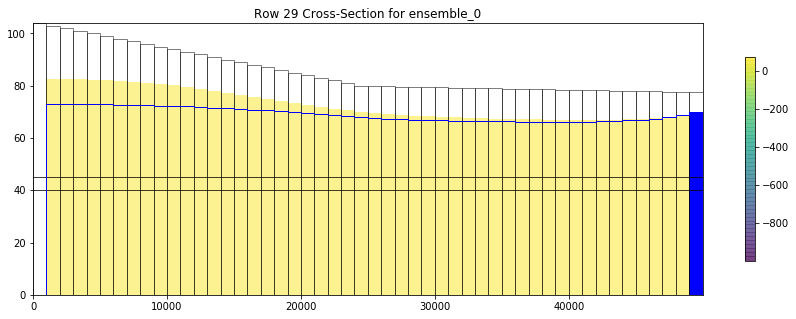

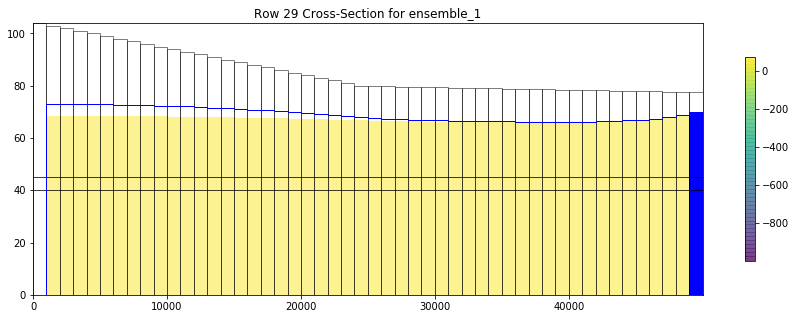

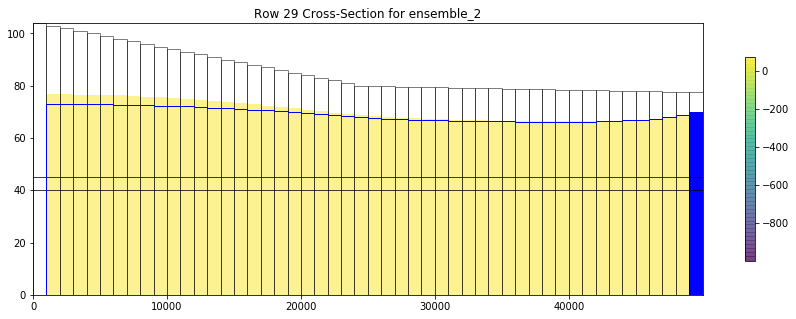

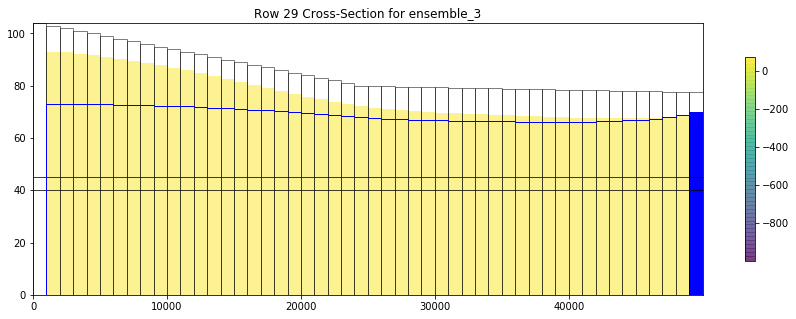

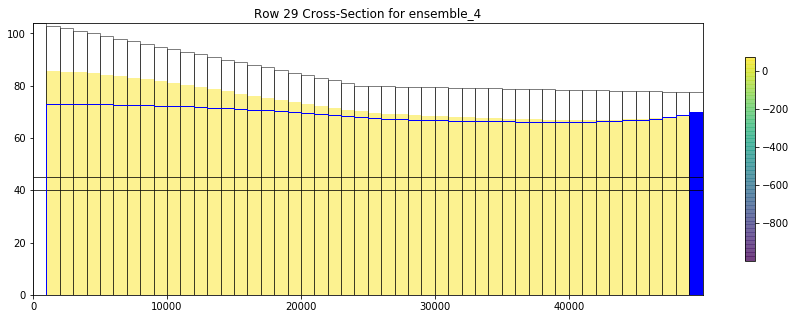

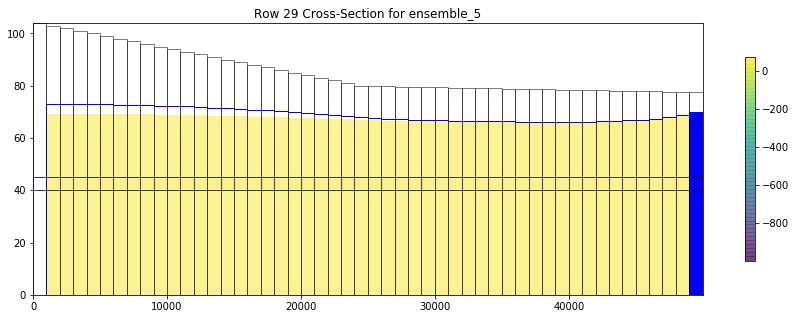

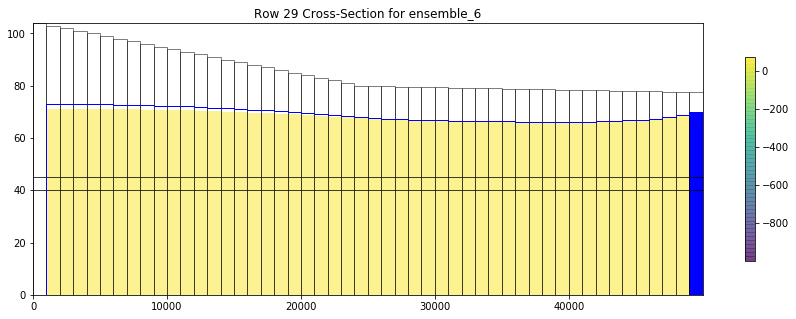

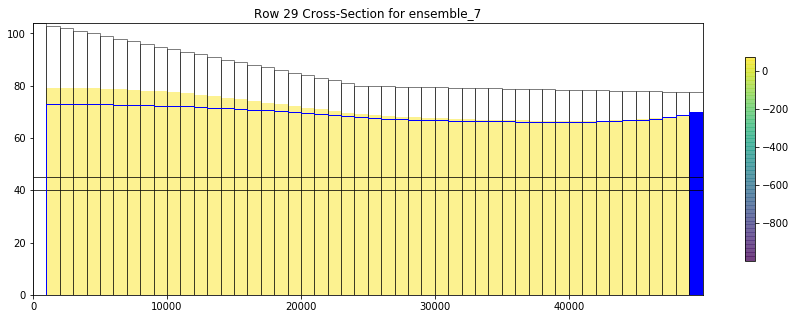

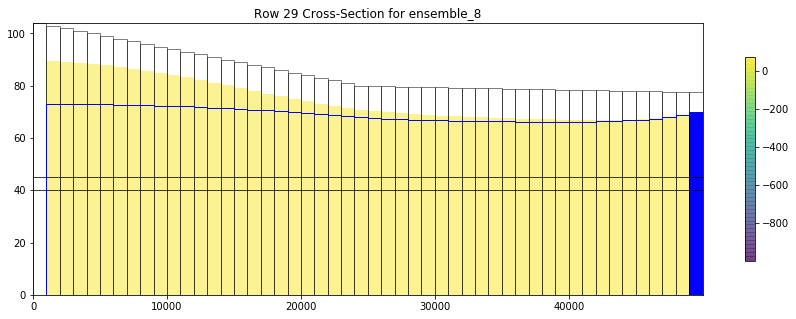

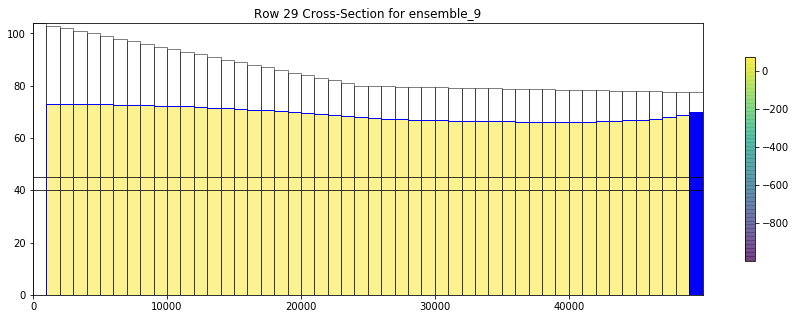

In [36]:

#loop start
for x in range(10):
    modelname = "ensemble_" + str(x)
    
    # Head - 1 layer model 
    headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
    times = headobj.get_times()                #returns a list of timesteps
    head = headobj.get_data(totim=times[-1])        #returns a numpy array of heads for specified time (last timestep)

    head_well = head[2,29,37]
    print("Head at Community well for", modelname , "=", head_well )

    # Crossection at Pumping Well row
    fig = plt.figure(figsize=(15, 5))
    ax = fig.add_subplot(1, 1, 1)

    xsect = flopy.plot.PlotCrossSection(model=m, line={'row': 29}) #note use the key 'column' if you want to plot a column instaed
    pc = xsect.plot_array(head1, masked_values=[999.], head=head, alpha=0.5)
    patches = xsect.plot_ibound(head=head1)
    #patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
    #patches = xsect.plot_bc('WEL', color='red')
    linecollection = xsect.plot_grid(color='black', lw=0.5)
    t = ax.set_title('Row 29 Cross-Section for ' f'{modelname}')
    #plt.xlabel('time (days)\n'f"Final Head = {head['sp%s'%(len(head)-1)][2, 29, 37]} m",fontweight='bold')

    cb = plt.colorbar(pc, shrink=0.75)
    #Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
    wt = xsect.plot_surface(head1[0,:,:], masked_values=[999.], color='blue', lw=1)
